In [1]:
import numpy as np
import pandas as pd
import gzip
import pickle
from collections import Counter
from utils import split_all_data
from scipy.stats import skew, kurtosis

import re
import spacy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# if you dont have the model uncomment the line below
#!python -m spacy download en_core_web_lg

In [ ]:
RANDOM_SEED = 2856

In [ ]:
spacy_model = spacy.load('en_core_web_lg')

def spacy_tokenizer(text):
    sp_text = spacy_model(text)
    tokens = [token.lemma_ for token in sp_text if (not token.is_stop and token.is_alpha)]
    return tokens

In [ ]:
stop_words = stopwords.words('english')

stemmer = PorterStemmer()
def stem_token(text):
    tokens = [stemmer.stem(word) for word in re.findall(r'\b\w\w+\b', text) if word not in stop_words]
    return tokens

In [ ]:
data_dict = split_all_data(.8, random_state=RANDOM_SEED)
train_df = data_dict['train']

Loading the data...
Splitting the data...


In [ ]:
%%timeit
spacy_tokenizer(train_df['tweet'].iloc[10][0])

20.2 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
stem_token(train_df['tweet'].iloc[10][0])

576 µs ± 24.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
# testing the tokenizer/lemmatizer
for item in train_df.sample(5).itertuples():
    tokenized = stem_token(item[3][0])
    count = Counter(tokenized)
    print(f'user: {item[1]} - label: {item[-1]}\n', count.most_common(10), '\n')

user: 562372370 - label: 1
 [('you', 3), ('either', 2), ('fight', 2), ('rt', 1), ('theriseofrod', 1), ('stand', 1), ('polic', 1), ('want', 1), ('kill', 1), ('america', 1)] 

user: 192283428 - label: 1
 [('rt', 1), ('skysportsnew', 1), ('break', 1), ('the', 1), ('nba', 1), ('postpon', 1), ('three', 1), ('schedul', 1), ('playoff', 1), ('game', 1)] 

user: 930835850 - label: 0
 [('zivoren', 1), ('told', 1), ('leah', 1), ('day', 1), ('probabl', 1), ('never', 1), ('go', 1), ('barber', 1)] 

user: 22156181 - label: 0
 [('yike', 1), ('http', 1), ('co', 1), ('4ickkw7jyn', 1)] 

user: 18796945 - label: 1
 [('the', 1), ('latest', 1), ('new', 1), ('you', 1), ('can', 1), ('use', 1), ('http', 1), ('co', 1), ('pvamyicu20', 1)] 



In [ ]:
def extract_topic_feature(row, components=None, random_state=None):
    if components is None:
        size4 = len(row)//4
        size2 = len(row)//2
        components = size2 if size2 > 2 else 2
    if row is not None:
        tweets = np.array(row)
        vectorize = TfidfVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1, 2), stop_words=None, min_df=1)
        nmf_model = NMF(n_components=components, init='nndsvd', max_iter=100000, random_state=random_state)
        nmf_pipe = make_pipeline(vectorize, nmf_model)
        
        
        W = nmf_pipe.fit_transform(tweets)
        
        index_max = []
        for index in range(W.shape[0]):
            max_val_index = np.argmax(W[index])
            index_max.append(max_val_index)
        index_norm = np.array(index_max) / len(row)
        
        return index_norm
    else:
        return np.nan

ID: 62934615 - Label 1
skew  0.3335530795273403
kurtosis  -1.1623246296775283
standard deviation  0.15290818746326876


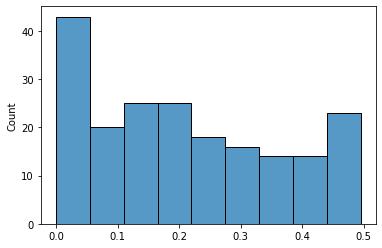

ID: 754677774703472640 - Label 1
skew  0.12639281857816853
kurtosis  -1.2380792456837404
standard deviation  0.1483015825101


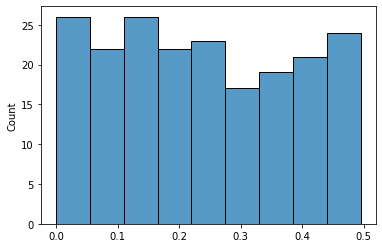

ID: 221549572 - Label 1
skew  0.12971564235462002
kurtosis  -1.3923574600521629
standard deviation  0.16232856714151403


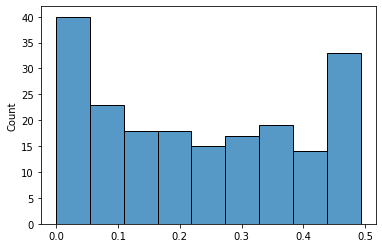

ID: 80096621 - Label 0
skew  0.20856699287301184
kurtosis  -1.2169884200075416
standard deviation  0.14875666161553908


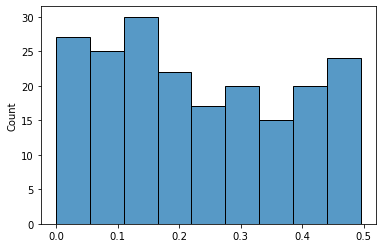

ID: 4853848397 - Label 1
skew  0.12823604858707857
kurtosis  -1.2296483991152867
standard deviation  0.15642827951249672


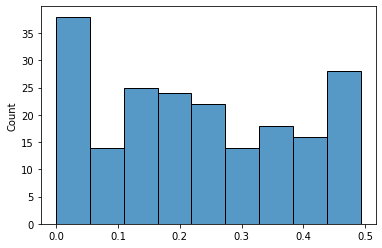

In [ ]:

for row in train_df.sample(5, random_state=RANDOM_SEED).itertuples():
    print(f"ID: {row[1]} - Label {row[-1]}")
    ind = extract_topic_feature(row[3])

    print('skew ', skew(ind))
    print('kurtosis ', kurtosis(ind))
    print('standard deviation ', ind.std())
    sns.histplot(ind)
    plt.show()

In [ ]:
def extract_nmf_feature(df):
    df.loc[:, 'topic_dist'] = df['tweet'].apply(extract_topic_feature)
    df.loc[:, 'topic_skew'] = df['topic_dist'].apply(skew)
    df.loc[:, 'topic_kurtosis'] = df['topic_dist'].apply(kurtosis)
    df.loc[:, 'std'] = df['topic_dist'].apply(lambda x: x.std())
    return df

In [ ]:
temp_df = train_df.iloc[:2, :]
extract_nmf_feature(temp_df)

C:\Users\alevink\AppData\Local\Temp/ipykernel_10304/2093341637.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'topic_dist'] = df['tweet'].apply(extract_topic_feature)
C:\Users\alevink\AppData\Local\Temp/ipykernel_10304/2093341637.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'topic_skew'] = df['topic_dist'].apply(skew)
C:\Users\alevink\AppData\Local\Temp/ipykernel_10304/2093341637.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

,ID,profile,tweet,neighbor,domain,label,topic_dist,topic_skew,topic_kurtosis,std
1912,2247952680,"{'id': '2247952680 ', 'id_str': '2247952680 ',...","[https://t.co/zV38EKB1oq\n, RT @aonwuachi: The...","{'following': ['29054836', '947330399411363840...",[Politics],1,"[0.0, 0.4444444444444444, 0.2777777777777778, ...",0.359083,-1.226580,0.156910
7214,165904582,"{'id': '165904582 ', 'id_str': '165904582 ', '...","[RT @prayingmedic: https://t.co/2BvGx5C5Gp\n, ...","{'following': ['813850311978811393', '80274482...",[Sports],1,"[0.055, 0.055, 0.31, 0.225, 0.225, 0.05, 0.065...",0.205801,-1.296491,0.155948
